In [1]:
import tensorflow as tf
import numpy as np
from tensorflow.keras import layers
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing import image_dataset_from_directory
from sklearn.model_selection import KFold
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc
import matplotlib.pyplot as plt

# Define Swin Transformer Block
class SwinTransformerBlock(layers.Layer):
    def __init__(self, dim, num_heads, window_size, ff_dim, **kwargs):
        super(SwinTransformerBlock, self).__init__(**kwargs)
        self.attention = layers.MultiHeadAttention(num_heads=num_heads, key_dim=dim)
        self.ffn = tf.keras.Sequential([
            layers.Dense(ff_dim, activation='relu'),
            layers.Dense(dim)
        ])
        self.norm1 = layers.LayerNormalization(epsilon=1e-6)
        self.norm2 = layers.LayerNormalization(epsilon=1e-6)

    def call(self, inputs):
        attn_output = self.attention(inputs, inputs)
        x = self.norm1(inputs + attn_output)
        ffn_output = self.ffn(x)
        return self.norm2(x + ffn_output)

# Define Swin Transformer Model
class SwinTransformer(layers.Layer):
    def __init__(self, embed_dim, depths, num_heads, window_size, ff_dim, **kwargs):
        super(SwinTransformer, self).__init__(**kwargs)
        self.blocks = [
            SwinTransformerBlock(
                dim=embed_dim,
                num_heads=num_heads[i],
                window_size=window_size,
                ff_dim=ff_dim
            )
            for i in range(len(depths))
        ]

    def call(self, inputs):
        x = inputs
        for block in self.blocks:
            x = block(x)
        return x

# Define Hybrid Model
class HybridModel(tf.keras.Model):
    def __init__(self, num_classes):
        super(HybridModel, self).__init__()
        self.cnn = MobileNetV2(include_top=False, input_shape=(224, 224, 3), weights="imagenet")
        self.reduce_dim = layers.Conv2D(128, kernel_size=1, padding="same")
        self.swin_transformer = SwinTransformer(
            embed_dim=128,
            depths=[2, 2, 6, 2],
            num_heads=[4, 8, 16, 32],
            window_size=7,
            ff_dim=256
        )
        self.global_pool = layers.GlobalAveragePooling2D()
        self.classifier = tf.keras.Sequential([
            layers.Dense(128, activation='relu'),
            layers.Dropout(0.5),
            layers.Dense(128, activation='relu'),
            layers.Dropout(0.4),
            layers.Dense(128, activation='relu'),
            layers.Dropout(0.3),
            layers.Dense(128, activation='relu'),
            layers.Dense(num_classes, activation='softmax')
        ])

    def call(self, inputs):
        cnn_features = self.cnn(inputs)
        reduced_features = self.reduce_dim(cnn_features)
        swin_features = self.swin_transformer(reduced_features)
        features = self.global_pool(swin_features)
        return self.classifier(features)

# Load Dataset
data_folder = "/kaggle/input/meinet-k/dataset_png"
batch_size = 32
img_size = (224, 224)

raw_dataset = image_dataset_from_directory(
    data_folder,
    image_size=img_size,
    batch_size=batch_size,
    label_mode='int',
    shuffle=True
)

class_names = raw_dataset.class_names
num_classes = len(class_names)
print(f"Class names: {class_names}")

dataset_images, dataset_labels = [], []
for image_batch, label_batch in raw_dataset.unbatch():
    dataset_images.append(image_batch.numpy())
    dataset_labels.append(label_batch.numpy())

dataset_images = np.array(dataset_images) / 255.0
dataset_labels = np.array(dataset_labels)

# Initialize and compile model
inputs = tf.keras.Input(shape=(224, 224, 3))
model = HybridModel(num_classes=num_classes)
outputs = model(inputs)
model = tf.keras.Model(inputs=inputs, outputs=outputs)

model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)
model.summary()




Found 3630 files belonging to 3 classes.
Class names: ['axial', 'coronal', 'sagittal']


Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ hybrid_model (HybridModel)           │ (None, 3)                   │       6,709,827 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,709,827 (25.60 MB)

 Trainable params: 6,675,715 (25.47 MB)

 Non-trainable params: 34,112 (133.25 KB)


Training fold 1...
Epoch 1/100
76/76 ━━━━━━━━━━━━━━━━━━━━ 112s 648ms/step - accuracy: 0.6413 - loss: 0.7830 - val_accuracy: 0.9967 - val_loss: 0.0374
Epoch 2/100
76/76 ━━━━━━━━━━━━━━━━━━━━ 9s 115ms/step - accuracy: 0.9798 - loss: 0.1111 - val_accuracy: 0.9959 - val_loss: 0.0186
Epoch 3/100
76/76 ━━━━━━━━━━━━━━━━━━━━ 9s 115ms/step - accuracy: 0.9934 - loss: 0.0431 - val_accuracy: 0.8488 - val_loss: 0.9746
Epoch 4/100
76/76 ━━━━━━━━━━━━━━━━━━━━ 9s 114ms/step - accuracy: 0.9957 - loss: 0.0244 - val_accuracy: 0.9686 - val_loss: 0.1866
Epoch 5/100
76/76 ━━━━━━━━━━━━━━━━━━━━ 9s 114ms/step - accuracy: 0.9980 - loss: 0.0132 - val_accuracy: 0.9876 - val_loss: 0.0954
Epoch 6/100
76/76 ━━━━━━━━━━━━━━━━━━━━ 9s 114ms/step - accuracy: 1.0000 - loss: 0.0071 - val_accuracy: 0.9901 - val_loss: 0.0808
Epoch 7/100
76/76 ━━━━━━━━━━━━━━━━━━━━ 9s 113ms/step - accuracy: 0.9985 - loss: 0.0118 - val_accuracy: 0.7198 - val_loss: 2.7289
Epoch 8/100
76/76 ━━━━━━━━━━━━━━━━━━━━ 9s 114ms/step - accuracy: 0.9963 - l

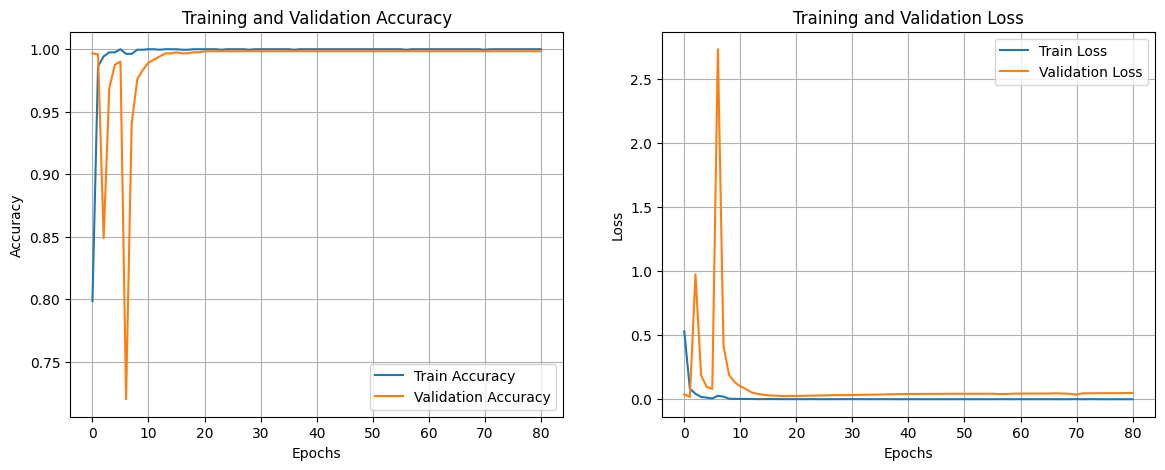

38/38 ━━━━━━━━━━━━━━━━━━━━ 9s 130ms/step

Classification Report:
              precision    recall  f1-score   support

       axial     0.9976    1.0000    0.9988       411
     coronal     1.0000    0.9953    0.9976       423
    sagittal     0.9973    1.0000    0.9987       376

    accuracy                         0.9983      1210
   macro avg     0.9983    0.9984    0.9984      1210
weighted avg     0.9984    0.9983    0.9983      1210



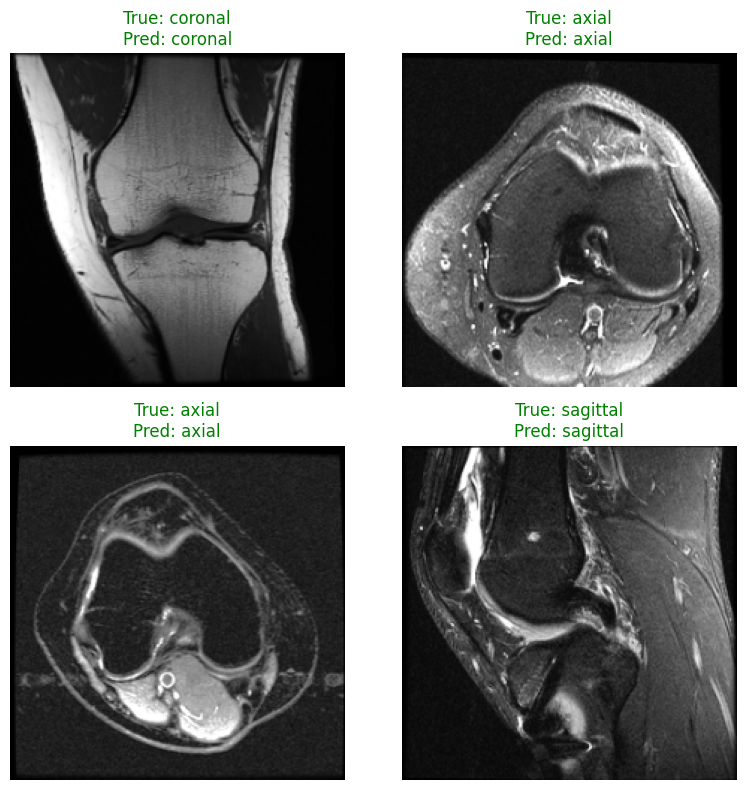

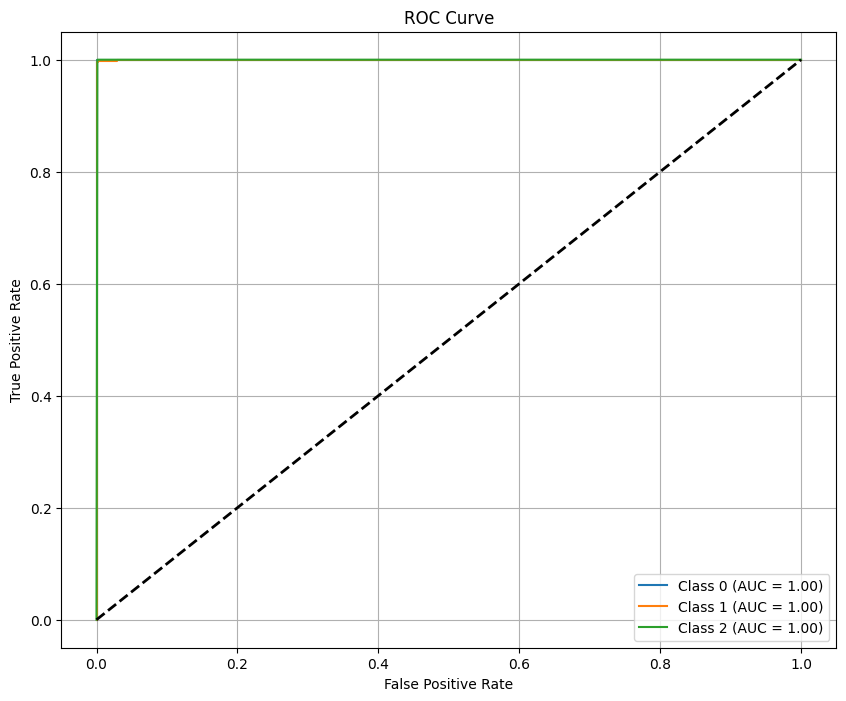

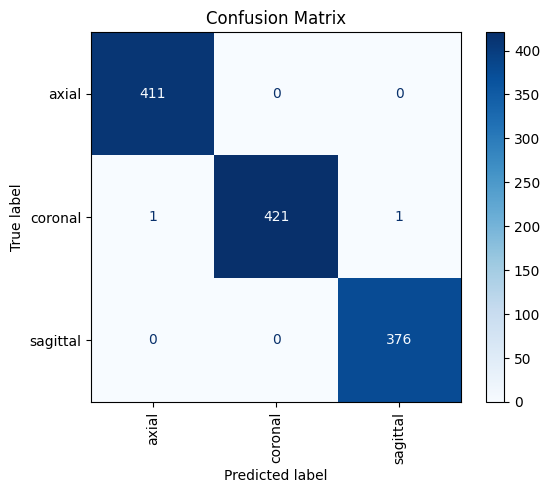


Training fold 2...
Epoch 1/100
76/76 ━━━━━━━━━━━━━━━━━━━━ 11s 125ms/step - accuracy: 0.9678 - loss: 0.2198 - val_accuracy: 0.9967 - val_loss: 0.0177
Epoch 2/100
76/76 ━━━━━━━━━━━━━━━━━━━━ 9s 113ms/step - accuracy: 0.9964 - loss: 0.0302 - val_accuracy: 0.9950 - val_loss: 0.0252
Epoch 3/100
76/76 ━━━━━━━━━━━━━━━━━━━━ 9s 114ms/step - accuracy: 0.9943 - loss: 0.0509 - val_accuracy: 0.9926 - val_loss: 0.0564
Epoch 4/100
76/76 ━━━━━━━━━━━━━━━━━━━━ 9s 114ms/step - accuracy: 0.9967 - loss: 0.0291 - val_accuracy: 0.9669 - val_loss: 0.1331
Epoch 5/100
76/76 ━━━━━━━━━━━━━━━━━━━━ 9s 114ms/step - accuracy: 0.9992 - loss: 0.0161 - val_accuracy: 0.9959 - val_loss: 0.0261
Epoch 6/100
76/76 ━━━━━━━━━━━━━━━━━━━━ 9s 114ms/step - accuracy: 0.9983 - loss: 0.0151 - val_accuracy: 0.9967 - val_loss: 0.0217
Epoch 7/100
76/76 ━━━━━━━━━━━━━━━━━━━━ 9s 115ms/step - accuracy: 0.9988 - loss: 0.0165 - val_accuracy: 0.9975 - val_loss: 0.0171
Epoch 8/100
76/76 ━━━━━━━━━━━━━━━━━━━━ 9s 113ms/step - accuracy: 0.9998 - lo

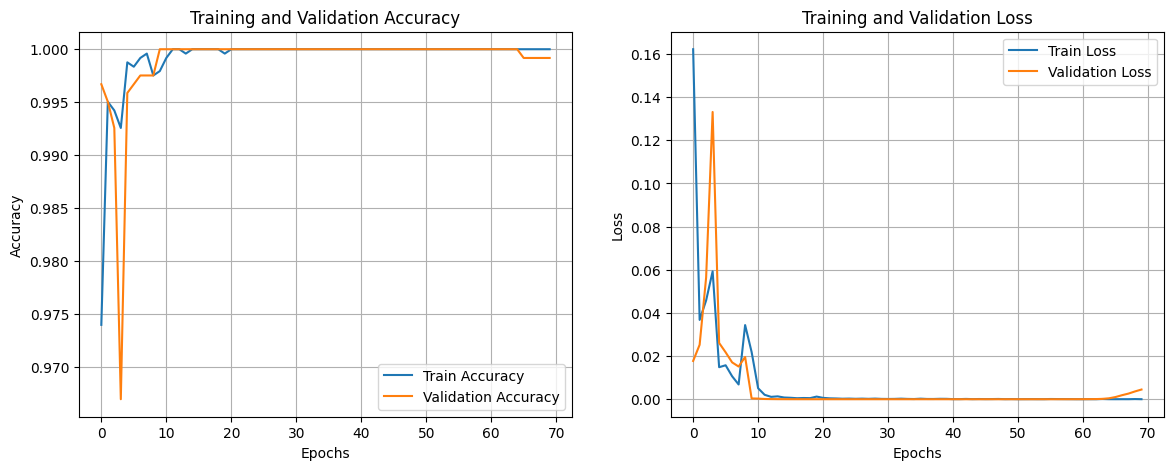

38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step

Classification Report:
              precision    recall  f1-score   support

       axial     1.0000    1.0000    1.0000       424
     coronal     1.0000    1.0000    1.0000       392
    sagittal     1.0000    1.0000    1.0000       394

    accuracy                         1.0000      1210
   macro avg     1.0000    1.0000    1.0000      1210
weighted avg     1.0000    1.0000    1.0000      1210



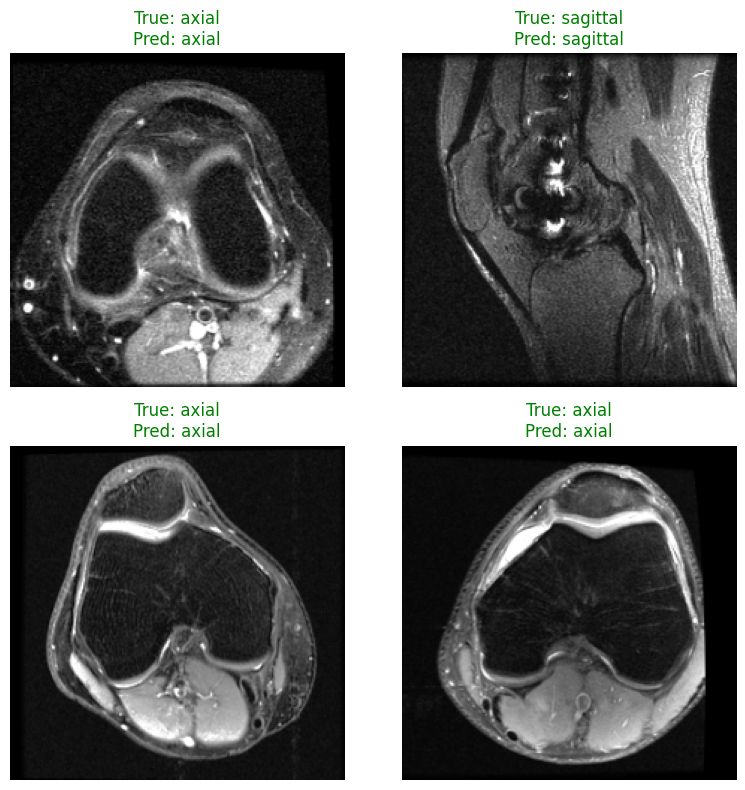

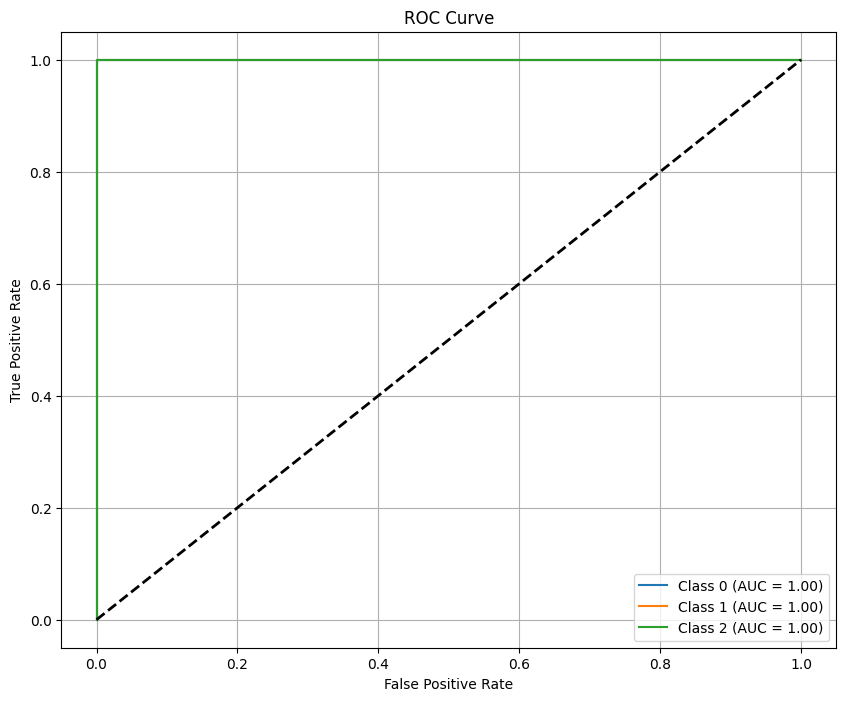

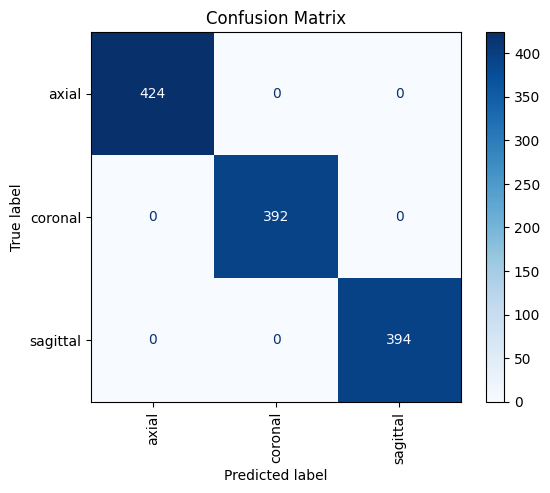


Training fold 3...
Epoch 1/100
76/76 ━━━━━━━━━━━━━━━━━━━━ 11s 125ms/step - accuracy: 0.9967 - loss: 0.0255 - val_accuracy: 0.9884 - val_loss: 0.0634
Epoch 2/100
76/76 ━━━━━━━━━━━━━━━━━━━━ 9s 114ms/step - accuracy: 0.9637 - loss: 0.1356 - val_accuracy: 0.7017 - val_loss: 1.5727
Epoch 3/100
76/76 ━━━━━━━━━━━━━━━━━━━━ 9s 114ms/step - accuracy: 0.9909 - loss: 0.0502 - val_accuracy: 0.8554 - val_loss: 0.4299
Epoch 4/100
76/76 ━━━━━━━━━━━━━━━━━━━━ 9s 114ms/step - accuracy: 0.9968 - loss: 0.0290 - val_accuracy: 0.9512 - val_loss: 0.2340
Epoch 5/100
76/76 ━━━━━━━━━━━━━━━━━━━━ 9s 113ms/step - accuracy: 0.9929 - loss: 0.0493 - val_accuracy: 0.8256 - val_loss: 0.7510
Epoch 6/100
76/76 ━━━━━━━━━━━━━━━━━━━━ 9s 114ms/step - accuracy: 0.9946 - loss: 0.0449 - val_accuracy: 0.8934 - val_loss: 0.7038
Epoch 7/100
76/76 ━━━━━━━━━━━━━━━━━━━━ 9s 114ms/step - accuracy: 0.9962 - loss: 0.0153 - val_accuracy: 0.9438 - val_loss: 0.3679
Epoch 8/100
76/76 ━━━━━━━━━━━━━━━━━━━━ 9s 114ms/step - accuracy: 0.9987 - lo

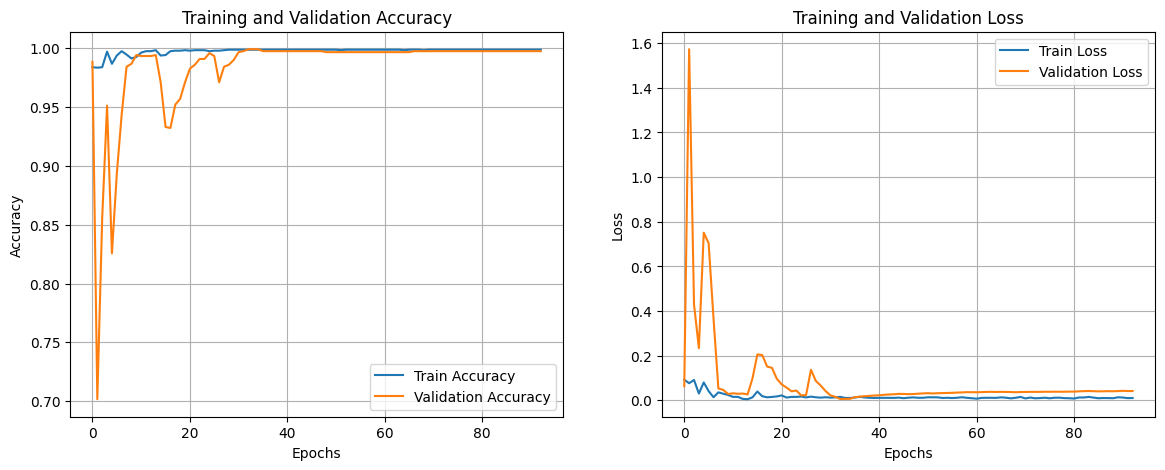

38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step

Classification Report:
              precision    recall  f1-score   support

       axial     1.0000    1.0000    1.0000       415
     coronal     0.9977    1.0000    0.9989       435
    sagittal     1.0000    0.9972    0.9986       360

    accuracy                         0.9992      1210
   macro avg     0.9992    0.9991    0.9992      1210
weighted avg     0.9992    0.9992    0.9992      1210



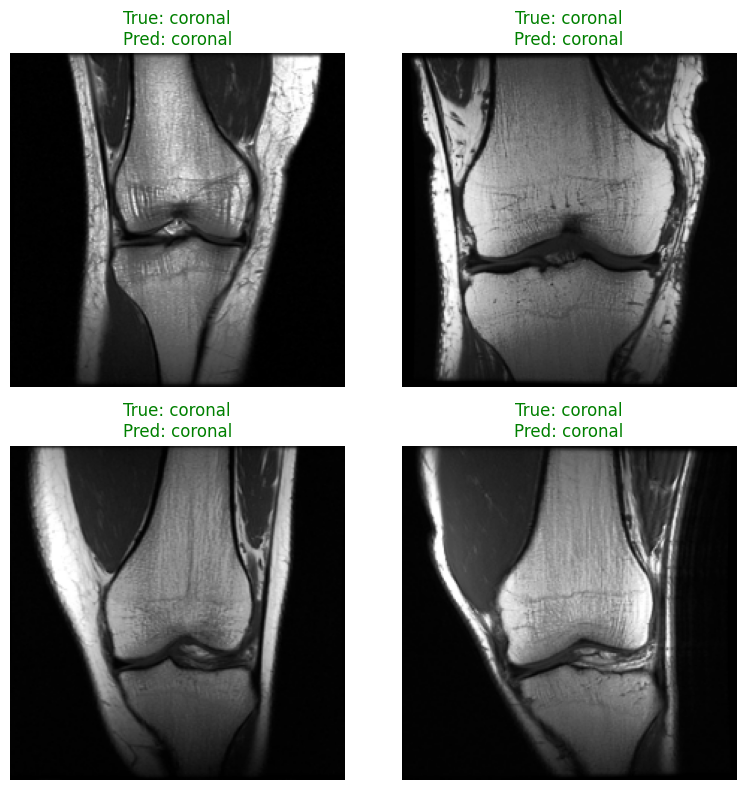

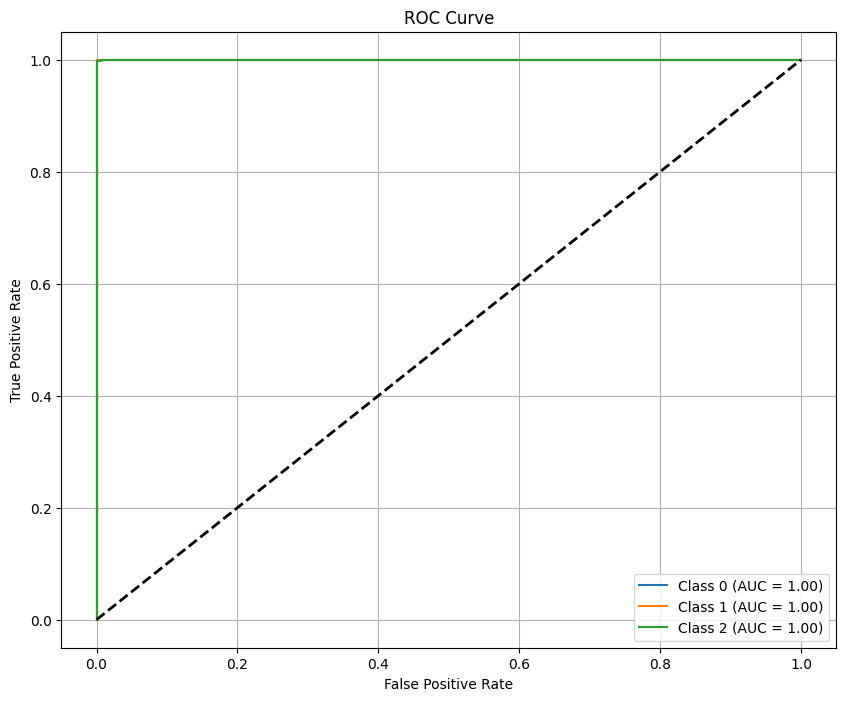

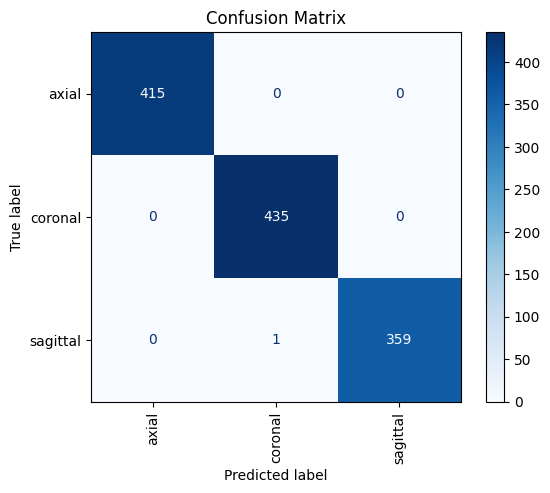

In [2]:
def plot_training_history(history):
    """
    Plot training and validation accuracy and loss.
    """
    plt.figure(figsize=(14, 5))
    
    # Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()
    plt.grid()

    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.grid()

    plt.show()

def plot_roc_curve(y_true, y_pred, num_classes):
    """
    Plot ROC curve for multi-class classification.
    """
    plt.figure(figsize=(10, 8))
    for i in range(num_classes):
        fpr, tpr, _ = roc_curve(y_true == i, y_pred[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'Class {i} (AUC = {roc_auc:.2f})')

    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc='lower right')
    plt.grid()
    plt.show()

def plot_confusion_matrix(y_true, y_pred, class_names):
    """
    Plot confusion matrix.
    """
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(cmap=plt.cm.Blues, xticks_rotation='vertical')
    plt.title("Confusion Matrix")
    plt.grid(False)
    plt.show()

def visualize_predictions(images, true_labels, pred_labels, class_names, num_samples=4):
    """
    Visualize a grid of predictions with their true and predicted labels.
    Properly rescales images for display.
    """
    num_samples = min(num_samples, len(images))
    indices = np.random.choice(len(images), num_samples, replace=False)
    grid_size = int(np.ceil(np.sqrt(num_samples)))

    plt.figure(figsize=(grid_size * 4, grid_size * 4))
    for i, idx in enumerate(indices):
        image = images[idx]
        true_label = true_labels[idx]
        pred_label = pred_labels[idx]

        # Rescale image for display (if needed)
        if image.max() <= 1.0:  # If normalized, scale back to [0, 255]
            image = (image * 255).astype("uint8")

        plt.subplot(grid_size, grid_size, i + 1)
        plt.imshow(image)
        plt.axis('off')
        plt.title(
            f"True: {class_names[true_label]}\nPred: {class_names[pred_label]}",
            color="green" if true_label == pred_label else "red"
        )

    plt.tight_layout()
    plt.show()


# K-Fold Cross-Validation Loop
kf = KFold(n_splits=3, shuffle=True, random_state=42)
fold = 1

for train_idx, val_idx in kf.split(dataset_images, dataset_labels):
    print(f"\nTraining fold {fold}...")

    # Reset model weights at the start of each fold
    model.set_weights(model.get_weights())

    train_images, val_images = dataset_images[train_idx], dataset_images[val_idx]
    train_labels, val_labels = dataset_labels[train_idx], dataset_labels[val_idx]

    train_dataset = tf.data.Dataset.from_tensor_slices((train_images, train_labels)).batch(batch_size)
    val_dataset = tf.data.Dataset.from_tensor_slices((val_images, val_labels)).batch(batch_size)

    # Callbacks
    lr_schedule = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)
    early_stopping = EarlyStopping(monitor='val_accuracy', patience=60 , restore_best_weights=True, verbose=1)

    # Train model
    history = model.fit(
        train_dataset,
        validation_data=val_dataset,
        epochs=100,  # Use smaller epochs for quick testing
        callbacks=[ early_stopping],
        verbose=1
    )

    # Plot training history
    plot_training_history(history)

    # Evaluate model
    val_predictions = model.predict(val_dataset)
    val_pred_classes = tf.argmax(val_predictions, axis=1).numpy()

    # Classification Report
    print("\nClassification Report:")
    print(classification_report(val_labels, val_pred_classes, target_names=class_names, digits=4))

    # Visualize predictions
    visualize_predictions(val_images, val_labels, val_pred_classes, class_names, num_samples=4)

    # Plot ROC Curve
    plot_roc_curve(val_labels, val_predictions, num_classes)

    # Plot Confusion Matrix
    plot_confusion_matrix(val_labels, val_pred_classes, class_names)

    fold += 1